In [74]:
import glob
import scipy.stats
import numpy as np
import pickle
import os

from collections import defaultdict
from itertools import combinations
from scipy import spatial
from metrics import rsa
from data import one_hot
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

baseline_path = 'runs/lstm_max_len_5_vocab_5_attr_4'

In [2]:
def get_run_name(run:str)->str:
    if run == 'lstm_max_len_5_vocab_5_attr_4':
        return 'baseline'
    else:
        return run
    
def plot_metric(paths, metric="loss", run='baseline', ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    runs = []
    
    for path in paths:
        # load the data
        seed_folders = glob.glob(f"{path}/*")

        result = {}
        # run through all seed
        for s in seed_folders:

            # get seed index
            seed = s.split("/")[-1]

            if seed == 'rsa_analysis.pkl':
                continue

            # get all metric files
            metric_files = glob.glob(s + "/*.pkl")

            for file in metric_files:

                # load files
                m1 = pickle.load(open(file, "rb"))

                # extract the iteration
                start = file.find('metrics')
                end = file.find('.pkl')
                iteration = file[start+11:end]
                generations.append(int(iteration))

                # append the metric value
                values.append(m1[metric])
                
                # append the run name
                runs.append(path[5:])
                
    values = np.array(values)
    iterations = np.array(generations)
    runs = np.array(runs)
    
    # voeg hier metrics toe
    #d = {'Iterations': iterations, "Run": runs, metric: values}
    #ax = sns.lineplot(ax=ax, x='Iterations', y=metric, hue="Run", data=pd.DataFrame(data=d))

    d = {'Iterations': iterations, metric: values}
    ax = sns.lineplot(ax=ax, x='Iterations', y=metric, data=pd.DataFrame(data=d))
    
    plt.ylabel('Accuracy')
    if title is None:
        title = metric.replace('_', ' ').title()
    #ax.set_title(title, fontsize=30)
    plt.show()

    
def plot_all_metric(results, metric="loss", runs="all", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
        
    run_names = []
    all_values = []
    all_iterations = []
    
    for r in list(results.keys()):
        # check which run the user would like to see
        if r == runs or runs=="all":
            
            values = []
            generations = []
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    #run_names.append(r)

            values = np.array(values)
            iterations = np.array(generations) 
            all_values.append(values)
            all_iterations.append(iterations)

    # initialize data dictionary
    d = {}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        if key == runs or runs=="all":
            d[key] = all_values[i]  
            d['Iterations'] = all_iterations[i]
    data_preproc=pd.DataFrame(data=d)

    # plot data
    ax = sns.lineplot(x='Iterations', y=metric, hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name=metric))
    
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()
    
def plot_rsa_metric(results, metric, ylabel=None, show_error=True, 
                    savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27), show=True):
    
    # initialize plots
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    # get data to fill up plot
    all_values = []
    for result in results.values():

        generations = []
        values = []
        run_names = []
        
        for s in list(result[metric].keys()):  
            
            # check if list is not empty
            if not list(result[metric][s].keys()):
                continue
                        
            for g in list(result[metric][s].keys()):
                                
#                 if int(g) == 10000:
#                     continue
                if g == 'generalize':
                    continue
                
                generations.append(g)
                values.append(result[metric][s][g])
                run_names.append(metric)

        values = np.array(values)
        iterations = np.array(generations)   
        all_values.append(values)
    
    # initialize data dictionary
    d = {'Iterations': iterations}
        
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        d[key] = all_values[i]    
    data_preproc=pd.DataFrame(data=d)

    ax = sns.lineplot(x='Iterations', y="RSA", hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name="RSA"))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)

    plt.show()


# TODO plot this in one figure

messages


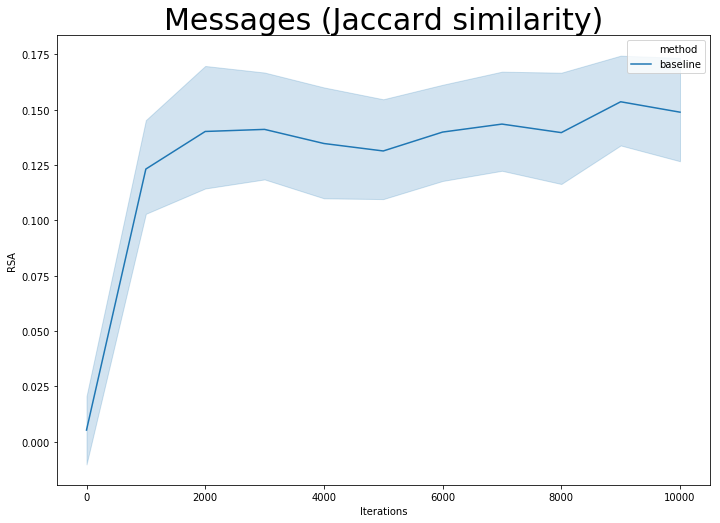

ham_messages


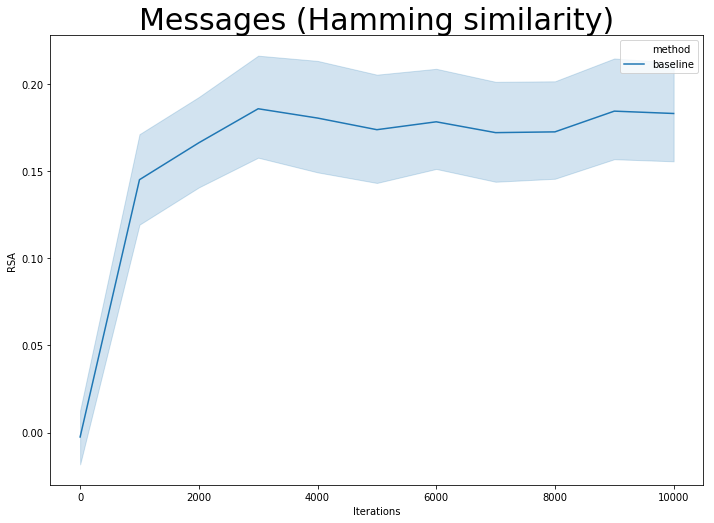

lev_messages


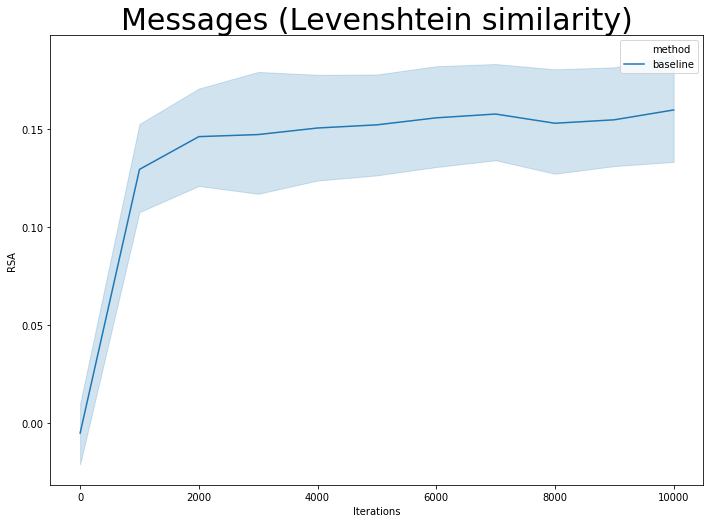

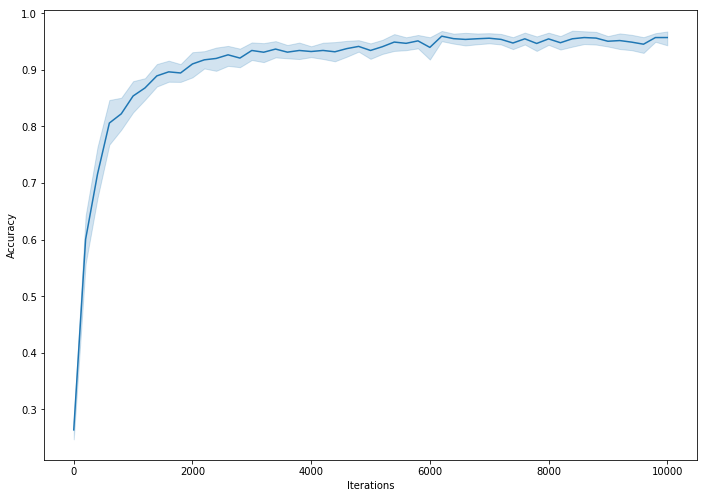

In [3]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))

#RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_attr_4/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'baseline': RSA_BASELINE}

for k in RSA_BASELINE:
    print(k)
    if k == "ham_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Hamming similarity)")
    elif k == "lev_messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Levenshtein similarity)")
    elif k =="messages":
        plot_rsa_metric(RSA_ANALYSIS, metric=k, title="Messages (Jaccard similarity)")
        
paths = [
        'runs/lstm_max_len_5_vocab_5_attr_5',
        ]

plot_metric(paths, 'acc', title='Accuracy')

# Similarity measure effect

In [4]:
# load RSA values of final iteration
def RSA(paths, metric="loss"):
    
    results = {}
    for path in paths:
        results[path] = {}
        for m in glob.glob(path + "/*/*.pkl"):

            seed = m.split('/')[2]
            if seed not in results[path]:
                results[path][seed] = {}

            it = m.split('_')[-1].split('.')[0]

            if it == 'metrics':
                continue

            iteration = int(it)
            
            # get the 

            results[path][seed][iteration] = pickle.load(open(m, 'rb'))
                
    return results

# load generalization scores
def load_metrics(path):
    """
        This function loads metrics at the end of an experiment
    """

    # load the data
    seed_folders = glob.glob(f"{path}/*")

    # save results
    generalize_result = {}
    generalize_related_result = {}
    train_result = {}

    # run through all seed
    for s in seed_folders:

        # get seed index
        seed = s.split("/")[-1]
        
        # make sure to ignore the rsa analysis for now
        if seed == 'rsa_analysis.pkl':
            continue

        # get all metric files
        metric_files = glob.glob(s + "/*.pkl")

        for file in metric_files:

            # load files
            m1 = pickle.load(open(file, "rb"))

            # check if file is generalize or train metric
            if file.find('generalize') == -1:
                if file.find('10000') != -1:
                    train_result[seed] = m1
            else:
                if file.find('generalize_related') == -1:
                    generalize_result[seed] = m1
                else:
                    generalize_related_result[seed] = m1
                                

    return train_result, generalize_result, generalize_related_result



# initialize data lists for averages and std

In [65]:
all_jacc_avg = []
all_ham_avg = []
all_lev_avg = []

all_jacc_std = []
all_ham_std = []
all_lev_std = []

# extract input rsa

In [67]:
paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4"]

def get_rsa(rsa, metric):

    # initialize empty list
    all_metric = []

    # extract data
    for s in range(1,11):
        
        # convert seed to string
        seed = str(s)

        # extract message to input space
        metric_rsa = rsa[path][seed][10000][metric]     
        all_metric.append(metric_rsa)

    return np.mean(all_metric), np.std(all_metric)
            
    
# extract rsa
rsa = RSA(paths)

for i, path in enumerate(paths):
    
    avg, std = get_rsa(rsa, metric='RSA:targets/messages')    
    all_jacc_avg.append(avg)
    all_jacc_std.append(std)
    
    avg, std = get_rsa(rsa, metric='RSA:targets/ham_messages')    
    all_ham_avg.append(avg)
    all_ham_std.append(std)
    
    avg, std = get_rsa(rsa, metric='RSA:targets/lev_messages')    
    all_lev_avg.append(-avg)
    all_lev_std.append(-std)
    
print(all_jacc_avg)
print(all_ham_avg)
print(all_lev_avg)


[0.344890863643072]
[0.3848164303227387]
[0.35110527582525564]


# extract cross seed

In [69]:
cross_seed = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_same_data_attr_4/rsa_analysis.pkl', 'rb'))
#print(cross_seed['messages'])


def cross_rsa(cross_seed):
    all_rsas_avg = {}
    all_rsas_std = {}
    
    # loop through rsa analysis
    for sim in cross_seed:

        # initialise values
        values = []

        # get the values    
        rsas = cross_seed[sim].values()

        # get the final values
        for r in rsas:
            values.append(r[10000])

        # append to dict
        all_rsas_avg[sim] = np.mean(values)
        all_rsas_std[sim] = np.std(values)
        
    return all_rsas_avg, all_rsas_std
        
all_rsas_avg, all_rsas_std = cross_rsa(cross_seed)

all_jacc_avg.append(all_rsas_avg['messages'])
all_ham_avg.append(all_rsas_avg['ham_messages'])
all_lev_avg.append(all_rsas_avg['lev_messages'])

all_jacc_std.append(all_rsas_std['messages'])
all_ham_std.append(all_rsas_std['ham_messages'])
all_lev_std.append(all_rsas_std['lev_messages'])



# plot

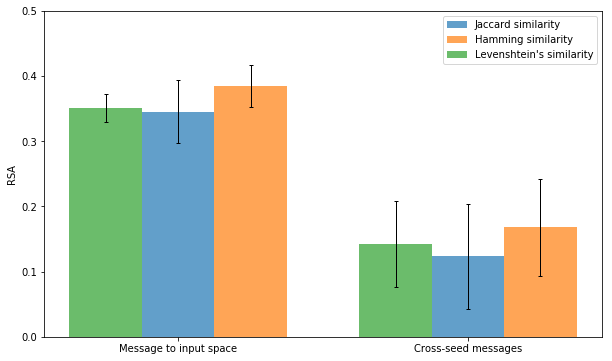

In [70]:
# figure stats
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(2)

# bar stats
bar_width = 0.25
opacity = 0.7

# plot the bar
jaccBar = ax.bar(index, all_jacc_avg, bar_width, yerr=all_jacc_std,
        alpha=0.7,
        error_kw=dict(lw=1, capsize=2, capthick=1),
        label='Jaccard similarity')

hamBar = ax.bar(index+0.25, all_ham_avg, bar_width, yerr=all_ham_std,
        alpha=0.7,
        error_kw=dict(lw=1, capsize=2, capthick=1),
        label='Hamming similarity')

levBar = ax.bar(index-0.25, all_lev_avg, bar_width, yerr=all_lev_std,
        alpha=0.7,
        error_kw=dict(lw=1, capsize=2, capthick=1),
        label='Levenshtein\'s similarity')
        
#plt.title('Comparison between strict and easy environment')

plt.xticks(index, tuple([i for i in seeds]))
ax.set_xticklabels(['Message to input space', 'Cross-seed messages'])


# create secondary y axis for accuracy

ax.set_ylim([0, 0.5])
ax.set_ylabel('RSA')

plt.legend()
plt.show()
        

# Data shuffle effect

In [76]:
################
# Extract data #
################

# create data shuffle plot
paths = ["runs/lstm_max_len_5_vocab_5_attr_4",
        "runs/lstm_max_len_5_vocab_5_same_data_attr_4"]

# extract rsa
rsa = RSA(paths)

mess_input_avg = defaultdict(list)
mess_input_std = defaultdict(list)

# loop through paths
for i, path in enumerate(paths):
    
    # get rsa values of data-messages
    avg, std = get_rsa(rsa, metric='RSA:targets/messages')    
    
    # extract cross-rsa analysis
    cross_seed = pickle.load(open(f'{path}/rsa_analysis.pkl', 'rb'))
    
    # extract cross seed
    all_rsas_avg, all_rsas_std = cross_rsa(cross_seed)
    
    mess_input_avg[i].append(avg)
    mess_input_std[i].append(std)

    mess_input_avg[i].append(all_rsas_avg['messages'])
    mess_input_std[i].append(all_rsas_std['messages'])


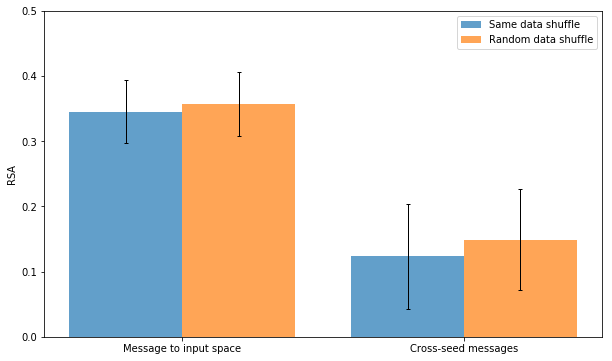

In [82]:
########
# Plot #
########

# figure stats
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(2)

# bar stats
bar_width = 0.4
opacity = 0.7

# plot the bar
sameBar = ax.bar(index-0.2, mess_input_avg[1], bar_width, yerr=mess_input_std[1],
        alpha=0.7,
        error_kw=dict(lw=1, capsize=2, capthick=1),
        label='Same data shuffle')

shuffleBar = ax.bar(index+0.2, mess_input_avg[0], bar_width, yerr=mess_input_std[0],
        alpha=0.7,
        error_kw=dict(lw=1, capsize=2, capthick=1),
        label='Random data shuffle')


#plt.title('Comparison between strict and easy environment')

plt.xticks(index, tuple([i for i in seeds]))
ax.set_xticklabels(['Message to input space', 'Cross-seed messages'])


# create secondary y axis for accuracy

ax.set_ylim([0, 0.5])
ax.set_ylabel('RSA')

plt.legend()
plt.show()

# Analyze language mappings -> loss in discretisation

In [ ]:
paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4"]

rsa = RSA(paths)

# initialize empty lists
all_jacc = []
all_ham = []
all_lev = []

for i, path in enumerate(paths):

    # bar stats
    bar_width = 0.25
    opacity = 0.7
    
    jacc = []
    ham = []
    lev = []
    # extract data
    
    for s in range(1,11):
        seed = str(s)
        
        # extract message to input space
        jaccard_mess = rsa[path][seed][10000]['RSA:targets/messages']
        hamming_mess = rsa[path][seed][10000]['RSA:targets/ham_messages']
        lev_mess = rsa[path][seed][10000]['RSA:targets/lev_messages']
        
        # extract message to receiver state
        jaccard_rec = rsa[path][seed][10000]['RSA:h_receiver/messages']
        hamming_rec = rsa[path][seed][10000]['RSA:h_receiver/ham_messages']
        lev_rec = rsa[path][seed][10000]['RSA:h_receiver/lev_messages']
        
        

    all_jacc.append(jaccard_mess)
    all_ham.append(hamming_mess)
    all_lev.append(lev_mess)
    
    jacc.append(jaccard_rec)
    ham.append(hamming_rec)
    lev.append(lev_rec)



all_jacc_avg.append(np.mean(all_jacc))
all_ham_avg.append(np.mean(all_ham))
all_lev_avg.append(-np.mean(all_lev))

all_jacc_std.append(np.std(all_jacc))
all_ham_std.append(np.std(all_ham))
all_lev_std.append(-np.std(all_lev)) 

all_jacc_avg.append(np.mean(jacc))
all_ham_avg.append(np.mean(ham))
all_lev_avg.append(-np.mean(lev))

all_jacc_std.append(np.std(jacc))
all_ham_std.append(np.std(ham))
all_lev_std.append(-np.std(lev)) 
    
print(all_jacc_avg)
print(all_ham_avg)
print(all_lev_avg)
